# <center>Data Mining Project 2 Spring semester 2019-2020</center>
## <center>Παναγιώτης Ευαγγελίου &emsp; 1115201500039</center>
## <center>Γεώργιος Μαραγκοζάκης &emsp; 1115201500089</center>

___

### Do all the necessary imports for this notebook

In [1]:
# data processing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# visualization
from wordcloud import WordCloud
from IPython.display import Image

# classification
from sklearn.model_selection import KFold
from IPython.display import display

# for data exploration
import os
import numpy as np


## __Dataset Preprocessing__

- ### *Make tsv files from all the txt files*

In [2]:
myCategoriesFolder = ['business','entertainment','politics', 'sport', 'tech']
dataPathDir = './fulltext/data/'

myDataSetDf = pd.DataFrame(columns=['ID', 'TITLE',  'CONTENT',  'CATEGORY'])
id_count = 0

for category in myCategoriesFolder:
    specificPath = dataPathDir + category + '/'

    # find the column's names of each csv
    for fileName in os.listdir(specificPath):
        # we need to check only .txt files
        if fileName.endswith(".txt"):
            
            thisTxt = open(os.path.join(specificPath, fileName),"r")
            thisTxtTitle = thisTxt.readline()

            # get rid of '\n' on the end of title line
            thisTxtTitle = thisTxtTitle.replace('\n', '')

            thisTxtContent = thisTxt.readlines()

            # get rid of empty lines '\n'
            thisTxtContent = list(filter(lambda a: a != '\n', thisTxtContent))

            # get rid of '\n' on the end of each line 
            thisTxtContent = [period.replace('\n', '') for period in thisTxtContent]

            # convert list of lines into a single string line
            thisTxtContent = ' '.join(thisTxtContent)

            myDataSetDf = myDataSetDf.append({'ID': id_count, 'TITLE': thisTxtTitle, 'CONTENT': thisTxtContent, 'CATEGORY': category.upper()}, ignore_index=True)
            thisTxt.close()

            id_count += 1

display(myDataSetDf)

,ID,TITLE,CONTENT,CATEGORY
0,0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,BUSINESS
1,1,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,BUSINESS
2,2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,BUSINESS
3,3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,BUSINESS
4,4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,BUSINESS
...,...,...,...,...
2220,2220,BT program to beat dialler scams,BT is introducing two initiatives to help beat...,TECH
2221,2221,Spam e-mails tempt net shoppers,Computer users across the world continue to ig...,TECH
2222,2222,Be careful how you code,A new European directive could put software wr...,TECH
2223,2223,US cyber security chief resigns,The man making sure US computer networks are s...,TECH


## __Make wordcloud for each category__

In [3]:
def makeWordCloud(myText, saveLocationPath, myMaxWords=100, myMask=None, myStopWords=None):
    '''Default function for generating wordcloud'''

    wc = WordCloud(background_color="white", mask=myMask, max_words=myMaxWords,
                   stopwords=myStopWords, contour_width=3, contour_color='steelblue',
                   width=600, height=600)

    # generate word cloud
    wc.generate(myText)

    # store to file

    wc.to_file(saveLocationPath)

    return saveLocationPath

In [4]:
def columnToText(myDfColumn):
    wholeColumnText = ''

    for text in myDfColumn:
        wholeColumnText = wholeColumnText + ' ' + text

    return wholeColumnText

- ### *Business Wordcloud*

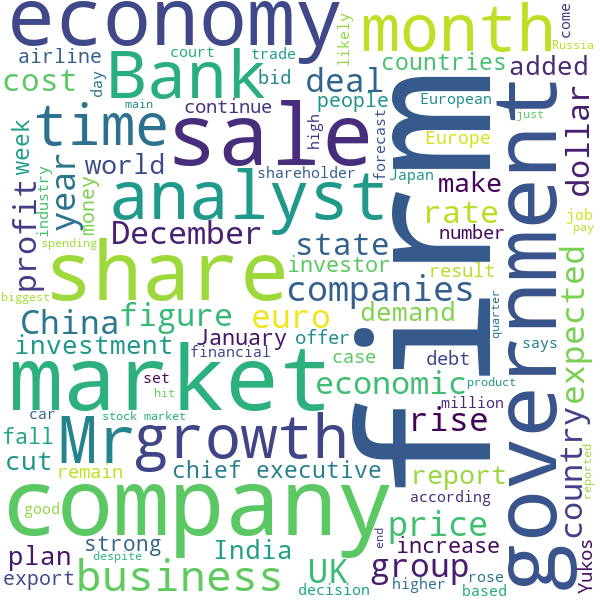

In [5]:
myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = ENGLISH_STOP_WORDS
stopWords = (stopWords.union(myAdditionalStopWords)).union(ENGLISH_STOP_WORDS)
makeWordCloud(saveLocationPath="businessWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "BUSINESS"]['CONTENT']), myStopWords=stopWords)

Image('businessWordCloud.png')


- ### *Entertainment Wordcloud*

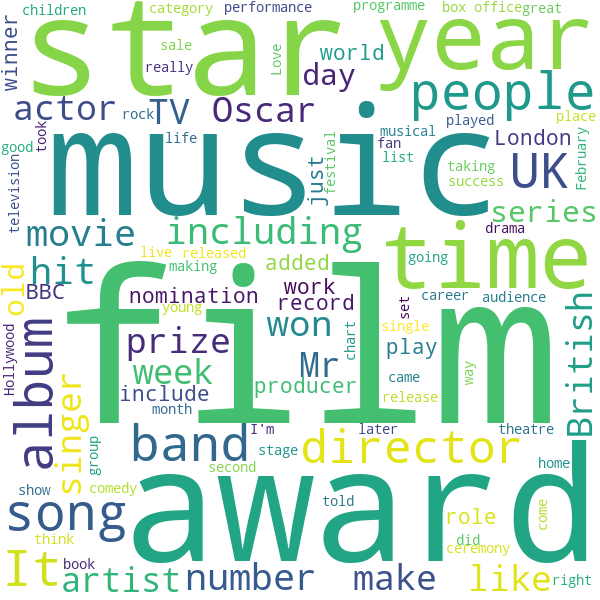

In [6]:

myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = ENGLISH_STOP_WORDS
stopWords = (stopWords.union(myAdditionalStopWords)).union(ENGLISH_STOP_WORDS)
makeWordCloud(saveLocationPath="entertainmentWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "ENTERTAINMENT"]['CONTENT']), myStopWords=stopWords)

Image('entertainmentWordCloud.png')


- ### *Politics Wordcloud*

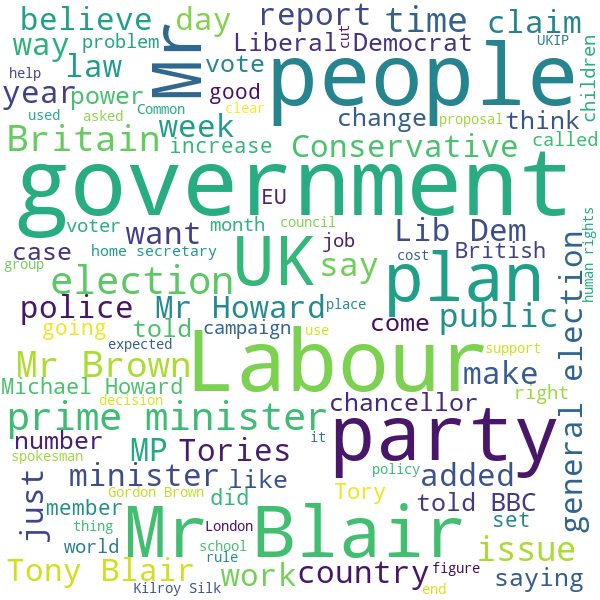

In [7]:

myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = ENGLISH_STOP_WORDS
stopWords = (stopWords.union(myAdditionalStopWords)).union(ENGLISH_STOP_WORDS)
makeWordCloud(saveLocationPath="politicsWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "POLITICS"]['CONTENT']), myStopWords=stopWords)

Image('politicsWordCloud.png')


- ### *Sport Wordcloud*

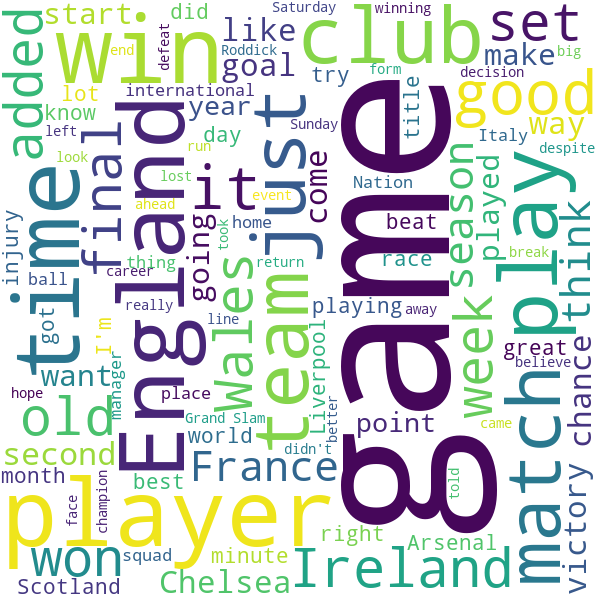

In [8]:

myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = ENGLISH_STOP_WORDS
stopWords = (stopWords.union(myAdditionalStopWords)).union(ENGLISH_STOP_WORDS)
makeWordCloud(saveLocationPath="sportWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "SPORT"]['CONTENT']), myStopWords=stopWords)

Image('sportWordCloud.png')


- ### *Tech Wordcloud*

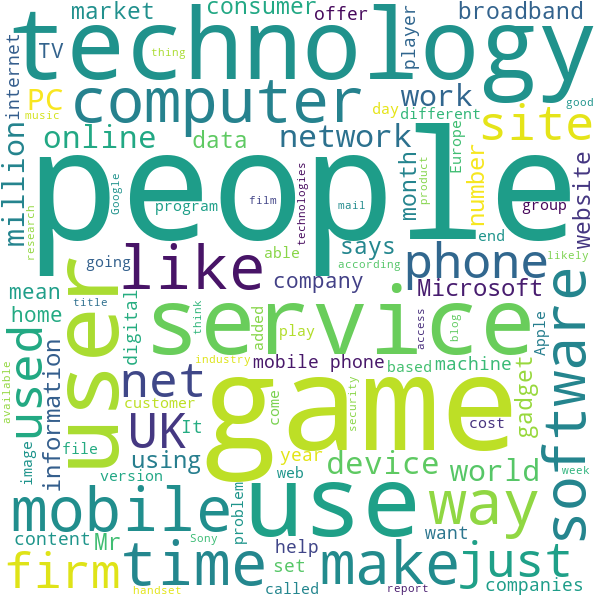

In [9]:

myAdditionalStopWords = ['say','said', 'new', 'need', 'year']
stopWords = ENGLISH_STOP_WORDS
stopWords = (stopWords.union(myAdditionalStopWords)).union(ENGLISH_STOP_WORDS)
makeWordCloud(saveLocationPath="techWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "TECH"]['CONTENT']), myStopWords=stopWords)

Image('techWordCloud.png')


## __Classification__

- ### *Split DataSet into TrainData and TestData*

In [10]:
trainDataSet, testDataSet = train_test_split(myDataSetDf, test_size=0.2, stratify=myDataSetDf['CATEGORY'])

# reset index
trainDataSet.reset_index(drop=True, inplace=True)
testDataSet.reset_index(drop=True, inplace=True)

# save to tsv files
trainDataSet.to_csv('train_set.tsv', sep = '\t')

# save test_set categories
testDataSetCategories = testDataSet[['CATEGORY']].copy()

testDataSetCategories.to_csv('test_set_categories.tsv', sep = '\t')

testDataSet = testDataSet.drop('CATEGORY', axis=1)
testDataSet.to_csv('test_set.tsv', sep = '\t')

In [11]:
myDataSetDf

,ID,TITLE,CONTENT,CATEGORY
0,0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,BUSINESS
1,1,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,BUSINESS
2,2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,BUSINESS
3,3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,BUSINESS
4,4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,BUSINESS
...,...,...,...,...
2220,2220,BT program to beat dialler scams,BT is introducing two initiatives to help beat...,TECH
2221,2221,Spam e-mails tempt net shoppers,Computer users across the world continue to ig...,TECH
2222,2222,Be careful how you code,A new European directive could put software wr...,TECH
2223,2223,US cyber security chief resigns,The man making sure US computer networks are s...,TECH


In [12]:
trainDataSet

,ID,TITLE,CONTENT,CATEGORY
0,1827,Digital guru floats sub-$100 PC,"Nicholas Negroponte, chairman and founder of M...",TECH
1,598,Oscar nominee Dan O'Herlihy dies,"Irish actor Dan O'Herlihy, who was nominated f...",ENTERTAINMENT
2,1668,Dawson joins England injury list,Scrum-half Matt Dawson is an injury doubt for ...,SPORT
3,1531,Hearts of Oak 3-2 Cotonsport,Hearts of Oak set up an all Ghanaian Confedera...,SPORT
4,176,Optimism remains over UK housing,The UK property market remains robust despite ...,BUSINESS
...,...,...,...,...
1775,1094,Game warnings 'must be clearer',Violent video games should carry larger warnin...,POLITICS
1776,2147,Apple attacked over sources row,Civil liberties group the Electronic Frontier ...,TECH
1777,265,Could Yukos be a blessing in disguise?,"Other things being equal, the notion of entrep...",BUSINESS
1778,956,Assembly ballot papers 'missing',Hundreds of ballot papers for the regional ass...,POLITICS


In [13]:
testDataSet

,ID,TITLE,CONTENT
0,2183,Confusion over high-definition TV,Now that a critical mass of people have embrac...
1,1998,Broadband in the UK growing fast,High-speed net connections in the UK are provi...
2,1796,Sydney return for Henin-Hardenne,Olympic champion Justine Henin-Hardenne will r...
3,695,Johnny and Denise lose Passport,Johnny Vaughan and Denise Van Outen's Saturday...
4,2075,Virus poses as Christmas e-mail,Security firms are warning about a Windows vir...
...,...,...,...
440,2143,PlayStation 3 processor unveiled,"The Cell processor, which will drive Sony's Pl..."
441,794,Rapper 50 Cent scores chart first,Rapper 50 Cent has become the first solo artis...
442,1787,Agassi fear for Melbourne,Andre Agassi's involvement in the Australian O...
443,628,Ring of Fire hit co-writer dies,"Merle Kilgore, co-writer of the country hit Ri..."


In [14]:
testDataSetCategories

,CATEGORY
0,TECH
1,TECH
2,SPORT
3,ENTERTAINMENT
4,TECH
...,...
440,TECH
441,ENTERTAINMENT
442,SPORT
443,ENTERTAINMENT


In [15]:
# use 10-fold cross validation
kf = KFold(n_splits=10)

In [16]:
kf

KFold(n_splits=10, random_state=None, shuffle=False)